# Data Exploration v2
Overzicht van machines, data coverage en patronen over tijd

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('data/NOx_intervals_with_belasting.csv')
df['time_interval'] = pd.to_datetime(df['time_interval'])
print(f"Totaal rijen: {len(df):,}")
print(f"Unieke machines: {df['device_id'].nunique()}")
print(f"Unieke timestamps: {df['time_interval'].nunique()}")
print(f"\nPeriode: {df['time_interval'].min()} tot {df['time_interval'].max()}")

Totaal rijen: 10,000
Unieke machines: 84
Unieke timestamps: 840

Periode: 2026-01-14 02:00:00 tot 2026-01-21 21:50:00


## Machine Categorieën

In [2]:
# Machines per categorie
cat_summary = df.groupby('MachineCategorie').agg(
    machines=('device_id', 'nunique'),
    rijen=('device_id', 'count')
).sort_values('machines', ascending=False)
cat_summary['rijen_per_machine'] = (cat_summary['rijen'] / cat_summary['machines']).astype(int)
print(cat_summary)

                      machines  rijen  rijen_per_machine
MachineCategorie                                        
Rupsgraafmachine            21   2440                116
Lader                       11   1320                120
Asfaltverwerking             8    960                120
Hijskraan                    8    960                120
Grondverzet                  7    840                120
Tractor                      7    840                120
Asfaltverdichting            6    720                120
Heistelling                  6    720                120
Generator                    4    480                120
Mobiele graafmachine         4    480                120
Overig                       2    240                120


In [3]:
# Rijen per machine
rows_per_machine = df.groupby('device_id').size()
print(f"Rijen per machine:")
print(f"  Min: {rows_per_machine.min()}")
print(f"  Max: {rows_per_machine.max()}")
print(f"  Gem: {rows_per_machine.mean():.0f}")
print(f"\nVerdeling:")
print(rows_per_machine.value_counts().sort_index())

Rijen per machine:
  Min: 40
  Max: 120
  Gem: 119

Verdeling:
40      1
120    83
Name: count, dtype: int64


## Machine Status over Tijd

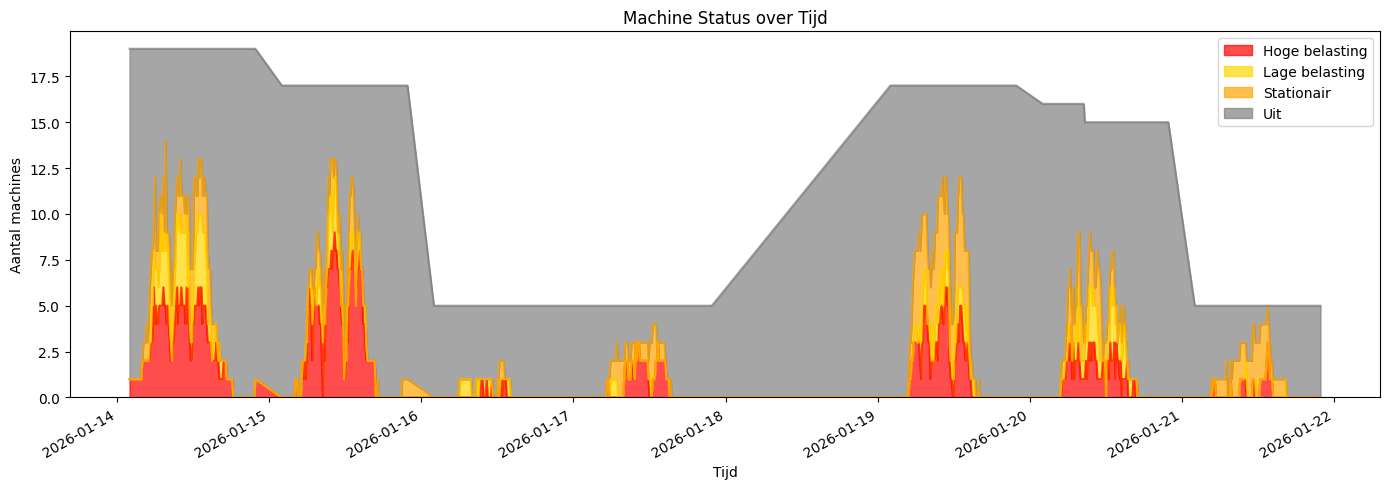

In [4]:
# Aantal actieve machines per tijdstip
status_over_time = df.groupby(['time_interval', 'belasting_categorie']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(14, 5))
status_over_time.plot.area(ax=ax, alpha=0.7, 
    color={'Uit': 'gray', 'Stationair': 'orange', 'Lage belasting': 'gold', 'Hoge belasting': 'red'})
ax.set_xlabel('Tijd')
ax.set_ylabel('Aantal machines')
ax.set_title('Machine Status over Tijd')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

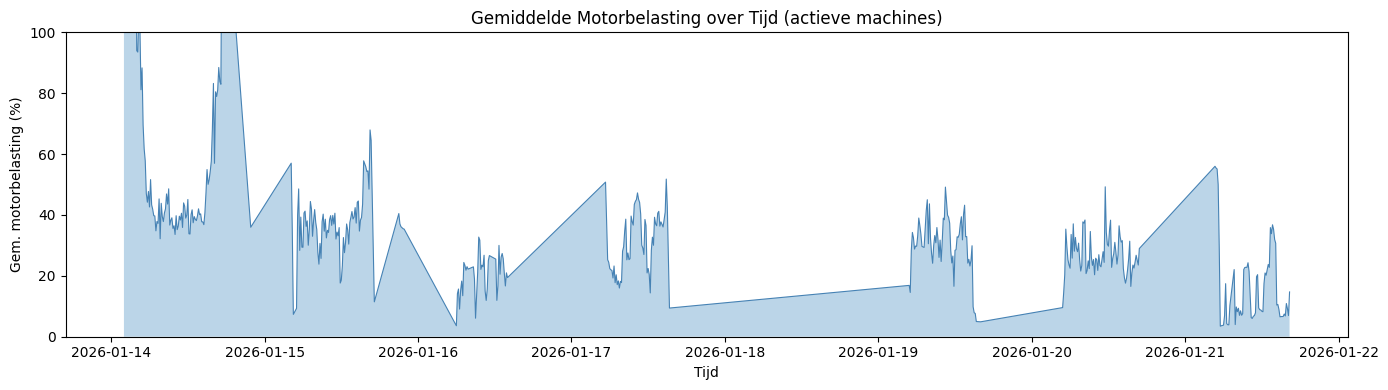

In [5]:
# Gemiddelde motorbelasting over tijd (alleen actieve machines)
active = df[df['belasting_categorie'] != 'Uit'].copy()
belasting_over_time = active.groupby('time_interval')['motorbelasting'].mean() * 100

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(belasting_over_time.index, belasting_over_time.values, color='steelblue', linewidth=0.8)
ax.fill_between(belasting_over_time.index, belasting_over_time.values, alpha=0.3)
ax.set_xlabel('Tijd')
ax.set_ylabel('Gem. motorbelasting (%)')
ax.set_title('Gemiddelde Motorbelasting over Tijd (actieve machines)')
ax.set_ylim(0, 100)
plt.tight_layout()
plt.show()

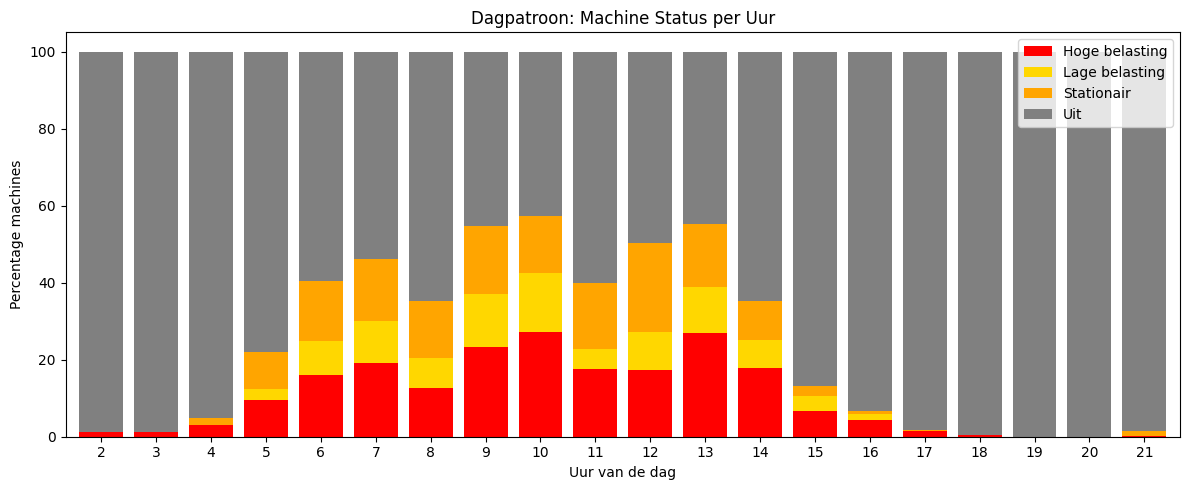

In [6]:
# Dagpatroon: gemiddeld per uur van de dag
df['hour'] = df['time_interval'].dt.hour

hourly_status = df.groupby(['hour', 'belasting_categorie']).size().unstack(fill_value=0)
hourly_status_pct = hourly_status.div(hourly_status.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(12, 5))
hourly_status_pct.plot.bar(ax=ax, stacked=True, 
    color={'Uit': 'gray', 'Stationair': 'orange', 'Lage belasting': 'gold', 'Hoge belasting': 'red'},
    width=0.8)
ax.set_xlabel('Uur van de dag')
ax.set_ylabel('Percentage machines')
ax.set_title('Dagpatroon: Machine Status per Uur')
ax.legend(loc='upper right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

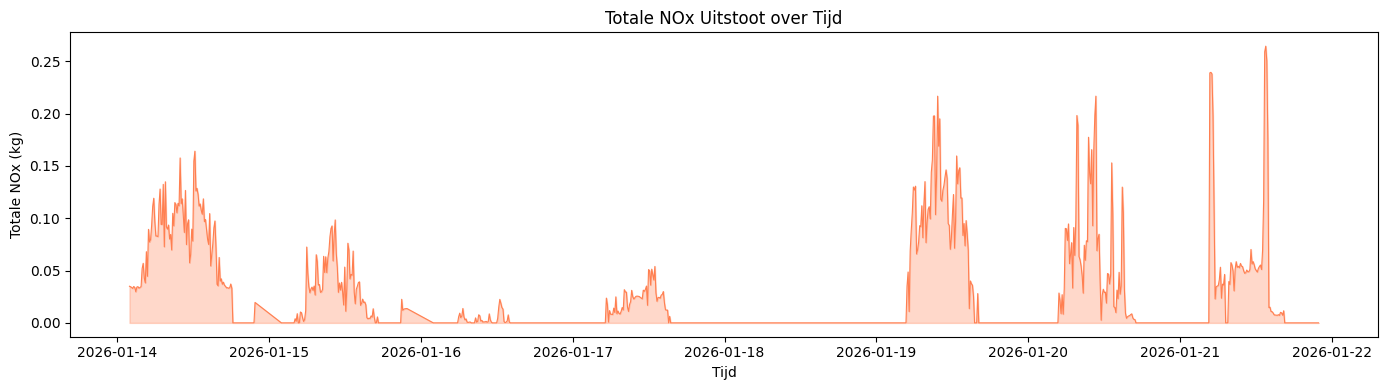

In [7]:
# NOx uitstoot over tijd
nox_over_time = df.groupby('time_interval')['NOx_mass_flow_kg'].sum()

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(nox_over_time.index, nox_over_time.values, color='coral', linewidth=0.8)
ax.fill_between(nox_over_time.index, nox_over_time.values, alpha=0.3, color='coral')
ax.set_xlabel('Tijd')
ax.set_ylabel('Totale NOx (kg)')
ax.set_title('Totale NOx Uitstoot over Tijd')
plt.tight_layout()
plt.show()

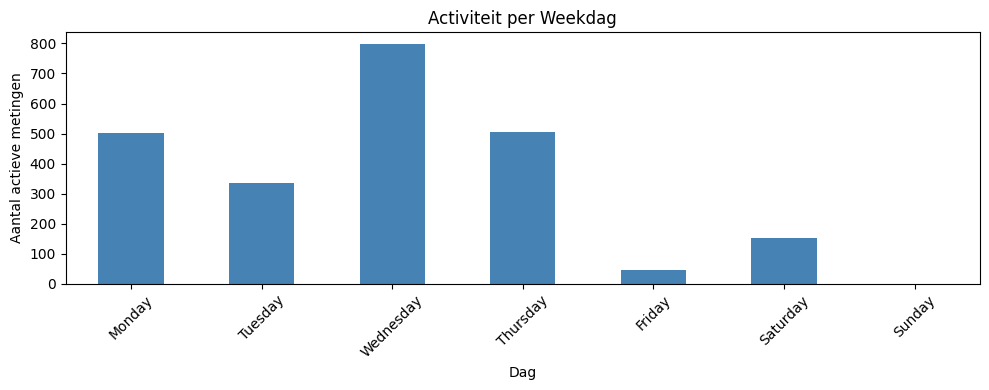

In [8]:
# Weekdag patroon
df['weekday'] = df['time_interval'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

active_by_day = df[df['belasting_categorie'] != 'Uit'].groupby('weekday').size()
active_by_day = active_by_day.reindex(weekday_order)

fig, ax = plt.subplots(figsize=(10, 4))
active_by_day.plot.bar(ax=ax, color='steelblue')
ax.set_xlabel('Dag')
ax.set_ylabel('Aantal actieve metingen')
ax.set_title('Activiteit per Weekdag')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()